In [1]:
from datetime import datetime
import torch
import requests
import cv2
from PIL import Image, ImageOps
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel, StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# cnmodel = "lllyasviel/sd-controlnet-openpose"
# controlnet = ControlNetModel.from_pretrained(
#     cnmodel,
#     torch_dtype=torch.float16,
#     use_auth_token=TOKEN,
# )
controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
]

device = "cuda"
i2ipl = "Lykon/DreamShaper"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    i2ipl,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
    # use_auth_token=TOKEN,
).to(device)

c:\Users\Genich\huggingface\.myvenv\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
from controlnet_aux import OpenposeDetector, HEDdetector
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')

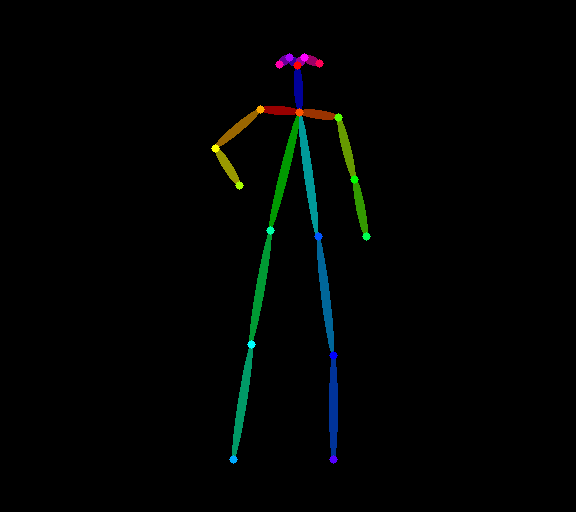

In [3]:
file_path = "pic/pose3.png"
init_image = Image.open(file_path).convert("RGB")
openpose_image = openpose(init_image)
openpose_image

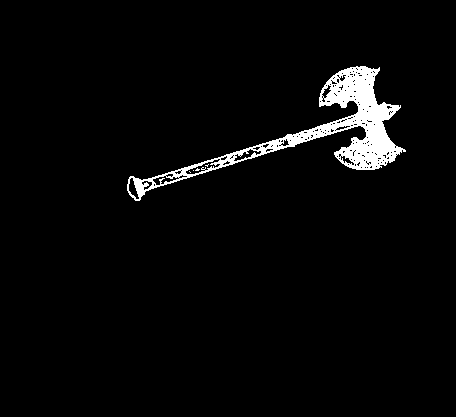

In [4]:
file_path = "pic/pose3_axe.png"
# init_image_bg = Image.open(file_path).convert("RGB")
# init_image_bg = init_image_bg.resize(init_image.size)
# sword = (load_image(file_path))
# sword
weapon = Image.open(file_path).convert("RGB")
weapon = ImageOps.invert(weapon)
weapon

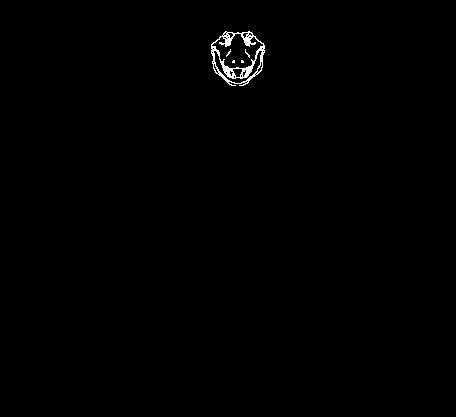

In [17]:
file_path_face = "pic/pose3_croco3.png"

# init_image_bg = Image.open(file_path).convert("RGB")
# init_image_bg = init_image_bg.resize(init_image.size)
# head = Image.open(file_path_face).convert("RGB")
# head = ImageOps.invert(head)
import numpy as np
arr = np.array(load_image(file_path_face))
head = cv2.Canny(arr,1,2)
head = head[:,:,None]
head = np.concatenate([head,head,head], axis=2)
head = Image.fromarray(head)
head
head = Image.open(file_path_face).convert("RGB")
head = ImageOps.invert(head)
head

  0%|          | 0/100 [00:00<?, ?it/s]

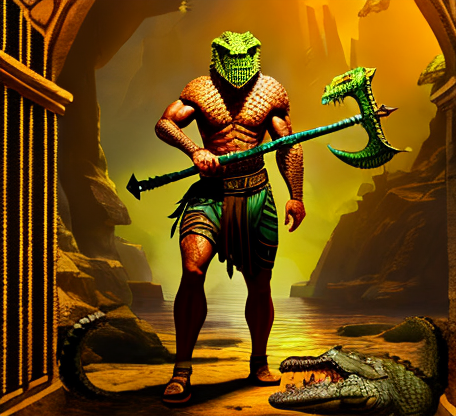

In [33]:
prompt = "Vicious Reptilian with crocodile head, looking at us, has a battle-axe, ancient Greek swamp, highly detailed, 4k"
negative_prompt = "monochrome, closeup, (deformed iris, deformed pupils, cgi, render, sketch, cartoon, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, negative_prompt=negative_prompt, image=[head, weapon, openpose_image], controlnet_conditioning_scale=[0.99, 0.8, 0.7], num_inference_steps=100, generator=generator).images[0]
now = datetime.now()
formatted_time = now.strftime("%Y%m%d%H%M%S")
image.save(f'pic/{formatted_time}.png')
image